# VOC Processing Data

## Code for processing availible data on Github

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO

### Sample Metadata

In [2]:
# ----------------------------------------------------------------------------------------------------#
# - Bring in public data -
# ----------------------------------------------------------------------------------------------------#

# Try and access file path of public data 
url = 'https://github.com/cshuler/VOC_Processing_Maui/blob/main/MASTER_Maui_VOC_Sheet_PUBLIC.csv?raw=true'
all_df = pd.read_csv(url,index_col=0)
di_variations = ['DI water', 'DI Water', 'DI', 'blank','BLANK', 'Blank', ' DI water','DI water ', 'Control']
#Filter the dataframe
all_df = all_df[~all_df['SampleType'].isin(di_variations)]
#all_df
print(all_df['SampleType'].unique())


['Tap Water' 'Tap Water Filtered' 'Pool/open water' nan
 'Livestock tank, non potable ' 'bottled water' 'Other' 'Tap water'
 'Tap Water ' 'Tap Water filtered' 'Tap Water Filtered ' 'Well'
 'Kitchen Tap' 'Tank' 'Cottage Tap']


### VOC data

In [3]:
# ----------------------------------------------------------------------------------------------------#
# - Bring in clean VOC data -
# ----------------------------------------------------------------------------------------------------#

#Function to get the list of CSV files from the GitHub repository page
def get_csv_files_from_repo(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        files = response.json()
        csv_files = [file['download_url'] for file in files if file['name'].endswith('.csv')]
        return csv_files
    else:
        raise ValueError(f"Failed to fetch repository contents: {response.status_code}")

#URL of the GitHub repository API
api_url = "https://api.github.com/repos/cshuler/VOC_Processing_Maui/contents/Clean_Data"

# Get the list of CSV files
csv_files = get_csv_files_from_repo(api_url)
csv_files
# Check if the list of CSV files is populated
if not csv_files:
    raise ValueError("No CSV files found in the repository")

# Function to read a CSV file from a URL into a DataFrame
def read_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad status codes
    return pd.read_csv(StringIO(response.text))

# Read all CSV files into a list of DataFrames and set 'Peak' as the index
dataframes = []
for url in csv_files:
    try:
        df = read_csv_from_url(url)
        df.set_index('Peak', inplace=True)
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading {url}: {e}")
# Ensure there are DataFrames to concatenate
if not dataframes:
    raise ValueError("No DataFrames were read successfully")

In [4]:
# ----------------------------------------------------------------------------------------------------#
# - Calc detects -
# ----------------------------------------------------------------------------------------------------#

def clean_numeric_data(df):
    """Clean data by removing problematic characters and coercing to numeric."""
    # Remove any leading/trailing spaces
    df = df.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
    
    # Convert all values to numeric (float), coercing errors to NaN
    df = df.apply(pd.to_numeric)
    
    return df
def compare_samples_to_limit(df):
    # Identify the reporting limit column
    limit_col = [col for col in df.columns if 'Reporting_Limit' in col][0]
    # Identify the sample columns (all columns except the reporting limit)
    sample_cols = [col for col in df.columns if col != limit_col]
    
    # Compare and set sample values
    for sample_col in sample_cols:
        df[sample_col] = df.apply(lambda row: np.nan if row[sample_col] < row[limit_col] else row[sample_col], axis=1)
    
    return df

# Process each DataFrame
for i, df in enumerate(dataframes):
    df.replace(['n.a.', 'n.a./n.r.'], np.nan, inplace=True)
    df.index = df.index.to_series().replace('Methylene chloride', 'Methylene chloride (DCM)')
    df.index = df.index.str.strip()
    df = clean_numeric_data(df)
    dataframes[i] = compare_samples_to_limit(df)  
df.head(5)
#ALL VALUES LESS THAN REPORTING LIMIT IS SET TO NAN#

/var/folders/ft/rj1gvr1d3q7b_prdsnsxp8y40000gn/T/ipykernel_59470/3667689256.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
/var/folders/ft/rj1gvr1d3q7b_prdsnsxp8y40000gn/T/ipykernel_59470/3667689256.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
/var/folders/ft/rj1gvr1d3q7b_prdsnsxp8y40000gn/T/ipykernel_59470/3667689256.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
/var/folders/ft/rj1gvr1d3q7b_prdsnsxp8y40000gn/T/ipykernel_59470/3667689256.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
/var/folders/ft/rj1gvr1d3q7b_prdsnsxp8y40000gn/T

,Reporting_Limit,10-25-24-KDP-01,10-25-24-KDP-02,10-25-24-KDP-03,10-25-24-KDP-04,10-25-24-KDP-05,10-25-24-KDP-06,10-25-24-KDP-07,10-25-24-KDP-08,10-25-24-KDP-09,10-25-24-KDP-10,10-25-24-KDP-11,10-25-24-KDP-12,10-25-24-KDP-13,10-25-24-KDP-14,10-25-24-KDP-15,10-25-24-KDP-16,10-25-24-KDP-17,10-25-24-KDP-18
Peak,,,,,,,,,,,,,,,,,,,
Chloromethane (methyl chloride),1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.8527,NaN
Chloroethene (vinyl chloride),1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bromomethane (methyl bromide),1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chloroethane (ethyl chloride),1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Trichlorofluoromethane,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Combine Datasets

In [5]:
# ----------------------------------------------------------------------------------------------------#
# - Combine both datasets -
# ----------------------------------------------------------------------------------------------------#

# Combine all DataFrames into one using an outer join to align the chemicals
combined_df = pd.concat(dataframes, axis=1, join='outer')

# Display the combined DataFrame
print("Combined DataFrame:")
combined_df.head()

Combined DataFrame:


,Reporting_Limit,HolmesTap,08-16-CKS-1,08-16-CKS-2,08-16-CKS-7,08-16-CKS-8,08-16-CKS-10,08-16-CKS-12,Reporting_Limit,DIH2O-Vial,...,10-25-24-KDP-09,10-25-24-KDP-10,10-25-24-KDP-11,10-25-24-KDP-12,10-25-24-KDP-13,10-25-24-KDP-14,10-25-24-KDP-15,10-25-24-KDP-16,10-25-24-KDP-17,10-25-24-KDP-18
Peak,,,,,,,,,,,,,,,,,,,,,
Chloromethane (methyl chloride),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.8527,NaN
Chloroethene (vinyl chloride),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bromomethane (methyl bromide),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chloroethane (ethyl chloride),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Trichlorofluoromethane,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Define chemical list

specified_chemicals = ["Chloromethane (methyl chloride)", "Chloroethene (vinyl chloride)", 
    "Bromomethane (methyl bromide)", "Chloroethane (ethyl chloride)",
    "Trichlorofluoromethane", "Diethyl ether", "1,1-Dichloroethene", "Acetone",
    "Iodomethane", "Carbon disulfide", "3-Chloropropene (allyl chloride)",
    "Methylene chloride (DCM)", "trans-1,2-Dichloroethene", "Methyl tert-butyl ether (MTBE)",
    "1,1-Dichloroethane", "2,2-Dichloropropane", "cis-1,2-Dichloroethene", "2-Butanone (MEK)",
    "Methyl acrylate", "Methacrylonitrile", "Bromochloromethane", "Tetrahydrofuran",
    "Trichloromethane (chloroform)", "1,1,1-Trichloroethane", "1-Chlorobutane (butyl chloride)", "Carbon tetrachloride",
    "1,1-Dichloropropene", "Benzene", "1,2-Dichloroethane",
    "Trichloroethene", "1,2-Dichloropropane", "Dibromomethane", "Methyl methacrylate",
    "Bromodichloromethane", "2-Nitropropane", "cis-1,3-Dichloropropene", "4-Methyl-2-pentanone (MIBK)", "Toluene", "trans-1,3-Dichloropropene", "Ethyl methacrylate",
    "1,1,2-Trichloroethane", "Tetrachloroethene", "1,3-Dichloropropane", "2-Hexanone",
    "Dibromochloromethane", "1,2-Dibromoethane (EDB)", "Chlorobenzene",
    "1,1,1,2-Tetrachloroethane", "Ethylbenzene", "m/p-Xylene", "o-Xylene", "Styrene",
    "Bromoform", "Isopropylbenzene (cumene)","Bromobenzene", "1,1,2,2-Tetrachloroethane", "1,2,3-Trichloropropane (TCP)",
    "trans-1,4-Dichloro-2-butene", "n-Propylbenzene", "2-Chlorotoluene", "1,3,5-Trimethylbenzene",
    "4-Chlorotoluene", "tert-Butylbenzene", "Pentachloroethane", "1,2,4-Trimethylbenzene",
    "1-Methylpropylbenzene (sec-butylbenzene)", "1,3-Dichlorobenzene", "4-Isopropyltoluene (p-cymene)", "1,4-Dichlorobenzene", "n-Butylbenzene", "1,2-Dichlorobenzene",
    "Hexachloroethane", "1,2-Dibromo-3-chloropropane (DBCP)", "Nitrobenzene", "1,2,4-Trichlorobenzene",
    "Hexachloro-1,3-butadiene", "Naphthalene", "1,2,3-Trichlorobenzene"
]

### Clean combined dataframe

In [7]:
filtered_combined_df = combined_df.loc[specified_chemicals]

# Transpose the filtered dataframe
transposed_df = filtered_combined_df.T

# Reset the index to turn columns into rows
transposed_df.reset_index(inplace=True)
transposed_df.rename(columns={'index': 'Sample ID'}, inplace=True)
transposed_df['Sample ID'] = transposed_df['Sample ID'].str.strip().str.upper()
all_df['Sample ID'] = all_df['Sample ID'].str.strip().str.upper()
id_mapping = {
    '03-11-24-01-JI': '03-11-24-JI-01',
    '03-20-24-JI-01': '3-20-24-JI-01',
    '03-20-24-JI-12': '3-20-24-JI-12',
    '11-07-CKS-05': '11-07-CKS-5',
    '03-20-CDS-10': '3-20-24-CES-10',
    '9-29-JES-1':'9-26-JES-1',
    '11-07-CKS-2':'11-07–CKS-2',
    '11-07-CKS-3':'11-07–CKS-3'
}

# Update the Sample IDs in all_df
all_df['Sample ID'] = all_df['Sample ID'].replace(id_mapping)

# Verify the changes
all_df.loc[all_df['Sample ID'].isin(id_mapping.values())]
all_sample_ids = set(all_df['Sample ID'])
transposed_sample_ids = set(transposed_df['Sample ID'])

# Identify mismatched Sample IDs
missing_in_transposed = all_sample_ids - transposed_sample_ids
missing_in_all = transposed_sample_ids - all_sample_ids

#missing_in_transposed, missing_in_all

merged_df = pd.merge(all_df, transposed_df, on='Sample ID', how='inner')
merged_sample_ids = set(merged_df['Sample ID'])
missing_in_merged = all_sample_ids - merged_sample_ids
missing_in_merged
#merged_df.head()
all_df.to_csv('All_samples.csv')

{'01-03-KDP-3',
 '01-19-KDP-06',
 '03-05-KDP-04',
 '03-20-24-JI-03',
 '03-20-24-JI-04',
 '03-20-24-JI-10',
 '03-20-24-JI-11',
 '04-23-24-CKS-1-HAIKU',
 '04-23-24-CKS-10 HAIKU',
 '04-23-24-CKS-11-HAIKU',
 '04-23-24-CKS-12-HAIKU',
 '04-23-24-CKS-2-HAIKU',
 '04-23-24-CKS-3 HAIKU',
 '04-23-24-CKS-4 HAIKU',
 '04-23-24-CKS-5 HAIKU',
 '04-23-24-CKS-6 HAIKU',
 '04-23-24-CKS-7-HAIKU',
 '04-23-24-CKS-8-HAIKU',
 '04-23-24-CKS-9 HAIKU',
 '08-25-CKS-31',
 '1-04-24-JI-01',
 '10-19-CDS-01',
 '10-19-CDS-02',
 '10-19-CDS-03',
 '10-19-CDS-04',
 '10-19-CDS-05',
 '10-19-CDS-06',
 '10-19-CDS-07',
 '10-19-CDS-08',
 '10-19-CDS-09',
 '11-03-CDS-1',
 '11-03-CDS-2',
 '11-03-CDS-3',
 '11-03-CDS-4',
 '11-03-CDS-5',
 '11-03-CDS-6',
 '11-03-CDS-7',
 '11-07–CKS-2',
 '11-07–CKS-3',
 '11-09-CDS-01',
 '11-09-CDS-02',
 '11-09-CDS-03',
 '11-09-CDS-04',
 '11-26-KDP-5',
 '11-26-KDP-9',
 '11-9-23-JI',
 '12-12-23-JI-04',
 '12-14-23-JI-03',
 '12-28-23-JI-01',
 '3-20-24-JI-02',
 '3-20-24-JI-14',
 '4-23-24-FIELD BLANK',
 '7755 

In [8]:
filtered_combined_df = combined_df.loc[specified_chemicals]

# Transpose the filtered dataframe
transposed_df = filtered_combined_df.T

# Reset the index to turn columns into rows
transposed_df.reset_index(inplace=True)
transposed_df.rename(columns={'index': 'Sample ID'}, inplace=True)
transposed_df['Sample ID'] = transposed_df['Sample ID'].str.strip().str.upper()
all_df['Sample ID'] = all_df['Sample ID'].str.strip().str.upper()
id_mapping = {
    '03-11-24-01-JI': '03-11-24-JI-01',
    '03-20-24-JI-01': '3-20-24-JI-01',
    '03-20-24-JI-12': '3-20-24-JI-12',
    '11-07-CKS-05': '11-07-CKS-5',
    '03-20-CDS-10': '3-20-24-CES-10',
    '9-29-JES-1':'9-26-JES-1',
    '11-07-CKS-2':'11-07–CKS-2',
    '11-07-CKS-3':'11-07–CKS-3'
}

# Update the Sample IDs in all_df
all_df['Sample ID'] = all_df['Sample ID'].replace(id_mapping)

# Verify the changes
all_df.loc[all_df['Sample ID'].isin(id_mapping.values())]
all_sample_ids = set(all_df['Sample ID'])
transposed_sample_ids = set(transposed_df['Sample ID'])

# Identify mismatched Sample IDs
missing_in_transposed = all_sample_ids - transposed_sample_ids
missing_in_all = transposed_sample_ids - all_sample_ids

#missing_in_transposed, missing_in_all

merged_df = pd.merge(all_df, transposed_df, on='Sample ID', how='inner')
merged_sample_ids = set(merged_df['Sample ID'])
missing_in_merged = all_sample_ids - merged_sample_ids
missing_in_merged
#merged_df.head()


### Calculate Total Trihalomethanes

In [9]:
def TTHM_Calculator(row):
    TTHM_List = ['Bromodichloromethane', 'Bromoform', 'Dibromochloromethane', 'Trichloromethane (chloroform)']
    empty_List = []
    
    for chemical in TTHM_List:
        value = row.get(chemical, np.nan)
        empty_List.append(value)
    
    TTHM = np.nansum(empty_List)  # Sum the list using nansum to treat NaNs as 0s
    return TTHM
merged_df['Total trihalomethanes (TTHMs)'] = merged_df.apply(TTHM_Calculator, axis=1)
merged_df.to_csv('All_samples.csv')

### Visualize detects

                           Chemical  Number of Detects
78    Total trihalomethanes (TTHMs)                620
7                           Acetone                532
22    Trichloromethane (chloroform)                455
33             Bromodichloromethane                303
44             Dibromochloromethane                248
52                        Bromoform                117
21                  Tetrahydrofuran                 47
17                 2-Butanone (MEK)                 46
11         Methylene chloride (DCM)                 16
0   Chloromethane (methyl chloride)                  7
9                  Carbon disulfide                  6
31                   Dibromomethane                  5
13   Methyl tert-butyl ether (MTBE)                  2
51                          Styrene                  1
20               Bromochloromethane                  1
1     Chloroethene (vinyl chloride)                  1
50                         o-Xylene                  0
2     Brom

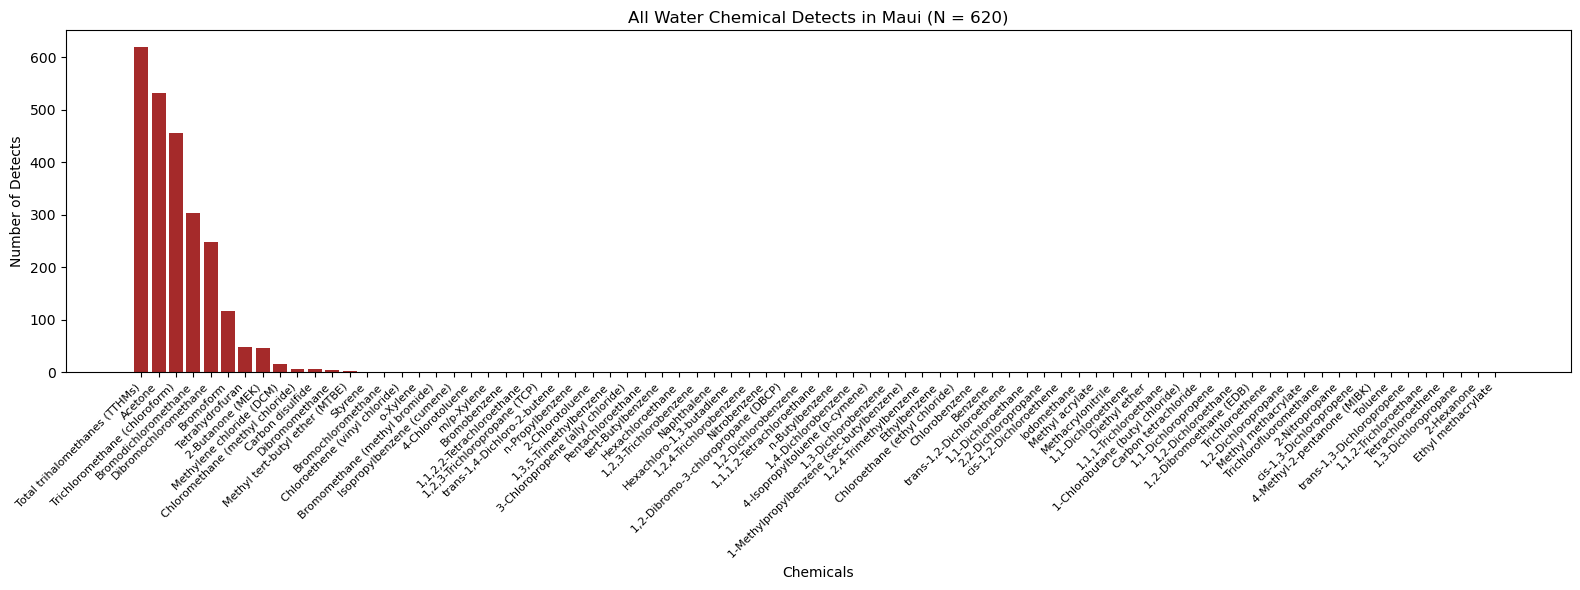

In [9]:
non_chemical_columns = ['Sample ID', 'SampleType', 'DateTime Taken', 'Public X', 'Public Y', 'Post Results']
chemical_columns = [col for col in merged_df.columns if col not in non_chemical_columns]
detect_counts = merged_df[chemical_columns].notna().sum()

# Total number of samples is the number of rows in merged_df
total_samples = len(merged_df)

# Create a DataFrame for plotting
detects_df = pd.DataFrame({
    'Chemical': detect_counts.index,
    'Number of Detects': detect_counts.values
}).sort_values(by='Number of Detects', ascending=False)
print(detects_df.head(18))

fig, ax = plt.subplots(figsize=(16, 6))  # Increase width to allow more spacing for labels

# Plot the bar chart
plt.bar('Chemical', 'Number of Detects', data=detects_df, color='brown')

# Rotate the x-axis labels and adjust their alignment
plt.xticks(rotation=45, ha='right', fontsize=8)

# Add more space between the x-ticks by reducing the number of ticks shown

# Title and labels
plt.xlabel("Chemicals")
plt.ylabel("Number of Detects")
plt.title(f'All Water Chemical Detects in Maui (N = {total_samples})')

# Adjust the layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

### Time-series plot of detect chemicals

In [10]:
detect_chemicals = ['Total trihalomethanes (TTHMs)',                     
'Trichloromethane (chloroform)',           
'Bromodichloromethane',          
'Dibromochloromethane',              
'Bromoform',               
'Tetrahydrofuran',                
'2-Butanone (MEK)',          
'Methylene chloride (DCM)',              
'Carbon disulfide',                 
'Dibromomethane',               
'Methyl tert-butyl ether (MTBE)',                  
'Chloromethane (methyl chloride)',                  
'Styrene',                  
'Bromochloromethane',               
'Chloroethene (vinyl chloride)',
'Benzene']

In [11]:
def parse_datetime(date_str):
    # List of potential datetime formats
    formats = [
        "%m/%d/%Y %H:%M:%S",   # e.g., 9/8/2023 15:10:00
        "%m/%d/%Y %H:%M:%S %p",# e.g., 1/4/2024 5:02:00 PM
        "%m/%d/%Y",            # e.g., 8/30/2024
        "%m-%d-%y",            # e.g., 8-14-24
        "%m-%d-%Y %H:%M:%S",   # e.g., 10-18-2024 8:30:00
        "%m-%d-%Y",            # e.g., 10-18-2024
    ]
    
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    # Return NaT if no format matches
    return pd.NaT

merged_df['DateTime Taken'] = (merged_df['DateTime Taken']).apply(parse_datetime)
merged_df['Benzene'] = merged_df['Benzene'].fillna(0)


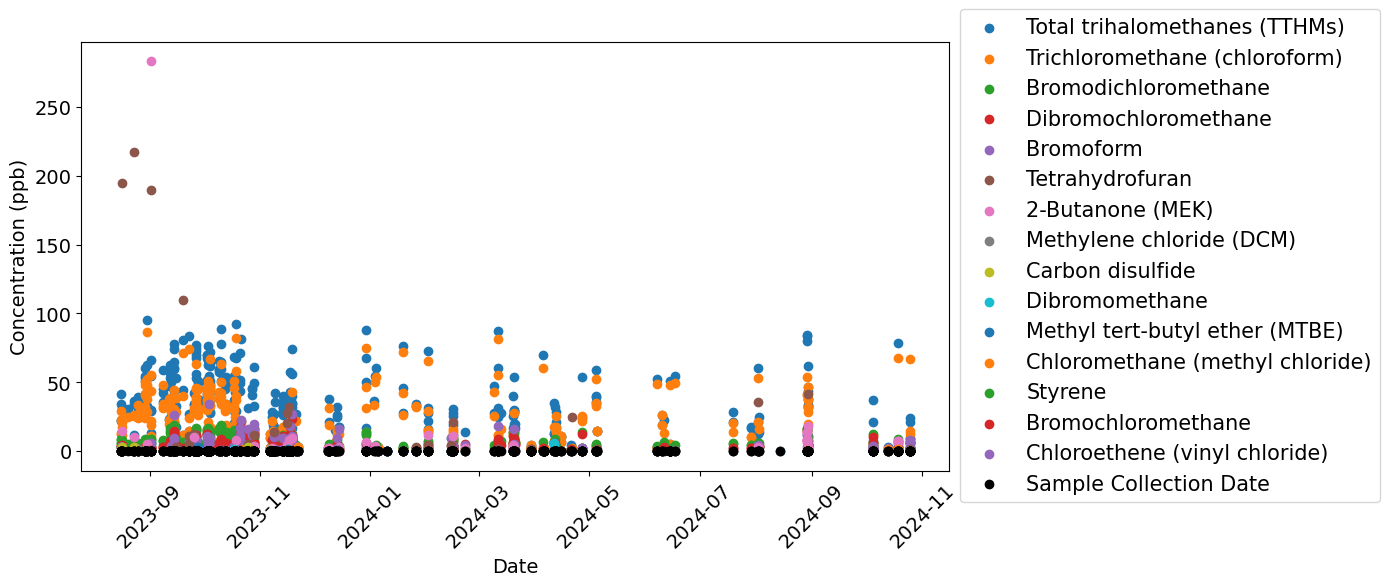

In [12]:
available_chemicals = [chem for chem in detect_chemicals if chem in merged_df.columns]
filtered_df = merged_df.loc[merged_df[detect_chemicals].notna().any(axis=1), ['DateTime Taken'] + detect_chemicals]
plt.figure(figsize=(14, 6))
for chem in detect_chemicals:
    if chem in filtered_df.columns:
        if chem == 'Benzene':
            plt.scatter(filtered_df['DateTime Taken'], filtered_df[chem], label='Sample Collection Date', color='black')
        else:
            plt.scatter(filtered_df['DateTime Taken'], filtered_df[chem], label=chem)

# Adding title, labels, and legend
#plt.title('Detected Chemical Concentrations Over Time',fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Concentration (ppb)',fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.1),fontsize=15)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid(False)
plt.show()

In [13]:
max_values = filtered_df[available_chemicals].max()
max_values

Total trihalomethanes (TTHMs)       95.2372
Trichloromethane (chloroform)       86.2655
Bromodichloromethane                19.3194
Dibromochloromethane                23.0434
Bromoform                           33.9244
Tetrahydrofuran                    216.9879
2-Butanone (MEK)                   282.9737
Methylene chloride (DCM)             2.9170
Carbon disulfide                     3.1450
Dibromomethane                       6.1698
Methyl tert-butyl ether (MTBE)       3.0089
Chloromethane (methyl chloride)     66.8527
Styrene                              1.2341
Bromochloromethane                   1.0367
Chloroethene (vinyl chloride)        1.6691
Benzene                              0.0000
dtype: float64